### Notebook to QC the Reynolds decomposition used to define energetics 

In [17]:
#Packages 
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime

import glob
from xhistogram.xarray import histogram
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.ticker as tick
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
from xhistogram.xarray import histogram
from datetime import timedelta
import time

import warnings
warnings.filterwarnings("ignore") #The chaotic option, used to suppress issues with cf_time with xroms 

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import pyplot as plt, patches

In [18]:
paths = '/d2/home/dylan/idealized_nummix/shelf_mpdata_uwind_zero_dt_30_60d_avg.nc'

def open_roms(path):
    ds1 = xroms.open_netcdf(path)
    ds1, grid1 = xroms.roms_dataset(ds1)
    ds1 = ds1.isel(ocean_time = slice(0,576))
    return ds1, grid1


ds, grid = open_roms(paths)

In [19]:
def energy_vint(ds,grid,xislice,etaslice):
    '''
Calculates volume-integrated eddy, mean, and total kinetic energy based on 
Hetland (2017) JPO.
Notes:
------
EKE = 1/2(uprime^2 + v^2). 
MKE = 1/2(ubar^2)
TKE = 1/2(u^2+v^2)
u = ubar+uprime, ubar = 1/L int_0^L u dx, i.e., alongshore mean
vbar = 0 by design.
Velocities interpolated to their respective rho points
    '''
    u = xroms.to_rho(ds.u, grid)
    u = u.isel(eta_rho = etaslice, xi_rho = xislice) 
    v = xroms.to_rho(ds.v, grid)
    v = v.isel(eta_rho = etaslice, xi_rho = xislice)
    ubar = u.mean('xi_rho')
    uprime = u-ubar
    vprime = v
    
    #Eddy kinetic energy
    eke = 0.5*(uprime**2 + vprime**2)
    dV = ds.dV.isel(eta_rho = etaslice, xi_rho = xislice)
    eke_int = (eke*dV).sum(['eta_rho', 'xi_rho', 's_rho']).load()
    eke_int.attrs = ''
    eke_int.name = 'eke'
    
    #Mean kinetic energy
    mke = 0.5*ubar**2
    mke_int = (mke*dV).sum(['eta_rho', 'xi_rho', 's_rho']).load()
    mke_int.attrs = ''
    mke_int.name = 'mke'
    
    #Total kinetic energy 
    tke = 0.5*(u**2+v**2)
    tke_int = (tke*dV).sum(['eta_rho', 'xi_rho', 's_rho']).load()
    tke_int.attrs = ''
    tke_int.name = 'tke'
    
    ds_energy = xr.merge([eke_int, mke_int, tke_int])
    return ds_energy
dse = energy_vint(ds,grid, slice(1,-1), slice(1,100))

In [21]:
def energy_vint1(ds,grid,xislice,etaslice):
    '''
Calculates volume-integrated eddy, mean, and total kinetic energy based on 
Hetland (2017) JPO.
Notes:
------
EKE = 1/2(uprime^2 + v^2). 
MKE = 1/2(ubar^2)
TKE = 1/2(u^2+v^2)
u = ubar+uprime, ubar = 1/L int_0^L u dx, i.e., alongshore mean
vbar = 0 by design.
Velocities interpolated to their respective rho points
    '''
    u = xroms.to_rho(ds.u, grid)
    u = u.isel(eta_rho = etaslice, xi_rho = xislice) 
    v = xroms.to_rho(ds.v, grid)
    v = v.isel(eta_rho = etaslice, xi_rho = xislice)
    ubar = u.mean('xi_rho')
    uprime = u-ubar
    
    vbar = v.mean('xi_rho')
    vprime = v-vbar
    
    #Eddy kinetic energy
    eke = 0.5*(uprime**2 + vprime**2)
    dV = ds.dV.isel(eta_rho = etaslice, xi_rho = xislice)
    eke_int = (eke*dV).sum(['eta_rho', 'xi_rho', 's_rho']).load()
    eke_int.attrs = ''
    eke_int.name = 'eke'
    
    #Mean kinetic energy
    mke = 0.5*ubar**2
    mke_int = (mke*dV).sum(['eta_rho', 'xi_rho', 's_rho']).load()
    mke_int.attrs = ''
    mke_int.name = 'mke'
    
    #Total kinetic energy 
    tke = 0.5*(u**2+v**2)
    tke_int = (tke*dV).sum(['eta_rho', 'xi_rho', 's_rho']).load()
    tke_int.attrs = ''
    tke_int.name = 'tke'
    
    ds_energy = xr.merge([eke_int, mke_int, tke_int])
    return ds_energy
dse1 = energy_vint1(ds,grid, slice(1,-1), slice(1,100))

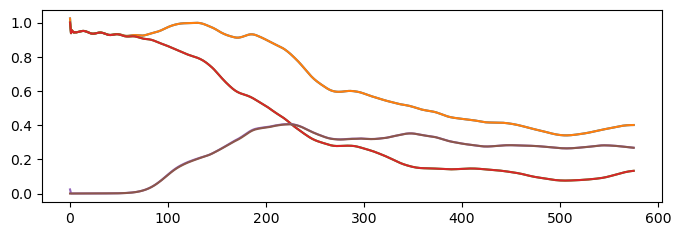

In [22]:
fig, ax = plt.subplots(1,1, figsize = (8,2.5))

plt.plot(dse.tke/dse.mke[0])
plt.plot(dse1.tke/dse.mke[0])

plt.plot(dse.mke/dse.mke[0])
plt.plot(dse1.mke/dse.mke[0])

plt.plot(dse.eke/dse.mke[0])
plt.plot(dse1.eke/dse.mke[0])

# Result is robust. Repeat with wind forcing 

In [24]:
paths = '/d2/home/dylan/idealized_nummix/shelf_mpdata_uwind_zerop1_dt_30_60d_avg.nc'

def open_roms(path):
    ds1 = xroms.open_netcdf(path)
    ds1, grid1 = xroms.roms_dataset(ds1)
    ds1 = ds1.isel(ocean_time = slice(0,576))
    return ds1, grid1


ds, grid = open_roms(paths)

In [25]:
dse = energy_vint(ds,grid, slice(1,-1), slice(1,100))
dse1 = energy_vint1(ds,grid, slice(1,-1), slice(1,100))

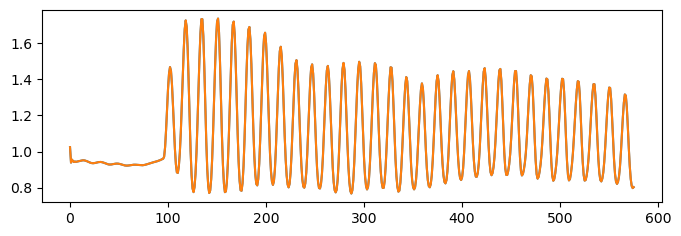

In [40]:
fig, ax = plt.subplots(1,1, figsize = (8,2.5))

plt.plot(dse.tke/dse.mke[0])
plt.plot(dse1.tke/dse.mke[0])

# plt.plot(dse.mke/dse.mke[0])
# plt.plot(dse1.mke/dse.mke[0])

# plt.plot(dse.eke/dse.mke[0])
# plt.plot(dse1.eke/dse.mke[0])

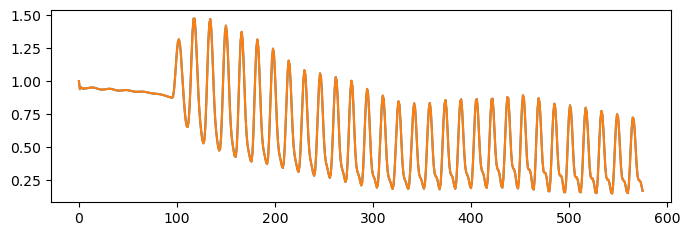

In [31]:
fig, ax = plt.subplots(1,1, figsize = (8,2.5))

# plt.plot(dse.tke/dse.mke[0])
# plt.plot(dse1.tke/dse.mke[0])

plt.plot(dse.mke/dse.mke[0])
plt.plot(dse1.mke/dse.mke[0])

# plt.plot(dse.eke/dse.mke[0])
# plt.plot(dse1.eke/dse.mke[0])

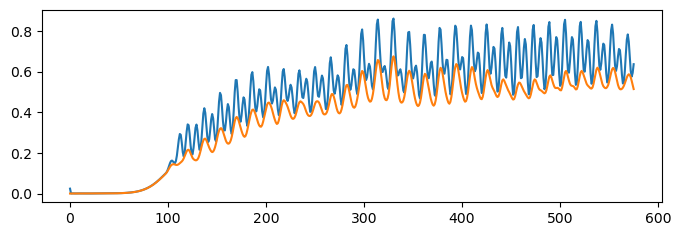

In [30]:
fig, ax = plt.subplots(1,1, figsize = (8,2.5))

# plt.plot(dse.tke/dse.mke[0])
# plt.plot(dse1.tke/dse.mke[0])

# plt.plot(dse.mke/dse.mke[0])
# plt.plot(dse1.mke/dse.mke[0])

plt.plot(dse.eke/dse.mke[0])
plt.plot(dse1.eke/dse.mke[0])

### Final QC check - sum MKE and EKE 

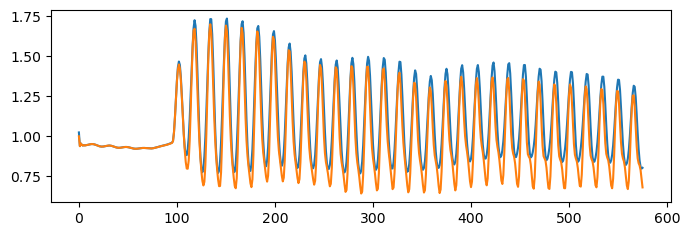

In [43]:
fig, ax = plt.subplots(1,1, figsize = (8,2.5))

# plt.plot(dse.tke/dse.mke[0])
plt.plot(dse1.tke/dse.mke[0])

# plt.plot(dse.mke/dse.mke[0])
# plt.plot(dse1.mke/dse.mke[0])

# plt.plot((dse.eke+dse.mke)/dse.mke[0])
plt.plot((dse1.eke+dse1.mke)/dse1.mke[0])

### When vprime is redefined, MKE and EKE do not sum to equal TKE. So, this is not correct. Means we didn't make a mistake 

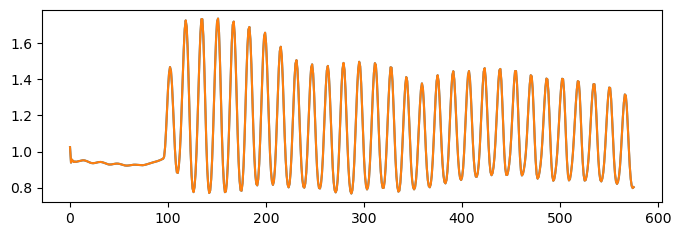

In [45]:
fig, ax = plt.subplots(1,1, figsize = (8,2.5))

# plt.plot(dse.tke/dse.mke[0])
plt.plot(dse1.tke/dse1.mke[0])

# plt.plot(dse.mke/dse.mke[0])
# plt.plot(dse1.mke/dse.mke[0])

plt.plot((dse.eke+dse.mke)/dse.mke[0])
# plt.plot((dse1.eke+dse1.mke)/dse1.mke[0])

### Conclusion - we do NOT need to define vprime, good to 